# Apply an Autoencoder to MNIST data

In [205]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.datasets
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [29]:
# Define transforms to apply on MNIST images to process data
train_dataset = torchvision.datasets.MNIST(root="./data/",
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

Test_dataset = torchvision.datasets.MNIST(root="./data/",
                                           train=False,
                                           transform=transforms.ToTensor())


In [31]:
val_dataset, test_dataset = torch.utils.data.random_split(Test_dataset, [0.5, 0.5])

In [32]:
# Create a Dataloader: Required for holding and feeding data in batches to a model
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=64,
                                               shuffle=True)

val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                               batch_size=64,
                                               shuffle=False) # Don't need this to be randomly shuffled

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=64,
                                              shuffle=False)

In [155]:
# How many batches in each dataloader
print(f"Training Batches: {len(train_dataloader)}")
print(f"Validation Batches: {len(val_dataloader)}")
print(f"Testing Batches: {len(test_dataloader)}")


Training Batches: 938
Validation Batches: 79
Testing Batches: 79


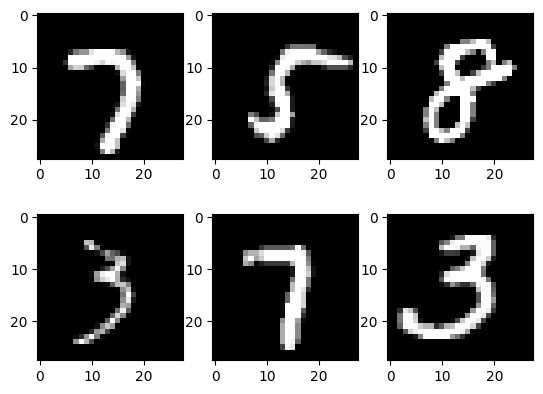

In [156]:
# View some data examples - batches are iterators
examples = iter(val_dataloader)
example_data, example_targets = next(examples)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [157]:
print(example_data.shape) # 64 images of 28 x 28 pixels and 1 channel
print(example_targets.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [206]:
# Write the AutoEncoder Class - reduce the size of the input
class Autoencoder(nn.Module):
  def __init__(self, dropout_rate=0.5):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128), # 784 -> 128
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(12, 3)
        )

    self.decoder=nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
            )

  def forward(self, x):
    encoded_features=self.encoder(x)
    reconstructed_input=self.decoder(encoded_features)
    return reconstructed_input

  def extract_latent_features(self, x):
    latent_features=self.encoder(x)
    return latent_features

In [207]:
model=Autoencoder()

#loss=nn.MSELoss()

def loss_fn(output, target, mse_ignore_val=0):

  z=output+target
  zero_mask=torch.where(z==mse_ignore_val, False, True)
  mse=(output-target)**2

  return torch.mean(torch.masked_select(mse, zero_mask))


optimiser=torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5,
)

# Learning rate scheduler
scheduler = StepLR(optimiser,
                   step_size=5,
                   gamma=0.1)


In [208]:
num_epochs=15

# Training Loop
epoch_outputs=[]

for epoch in range(num_epochs):
  train_outputs=[]
  val_outputs=[]

  # Perform training loop
  model.train()
  for idx, (img, label) in enumerate(train_dataloader):
    flattened_img=img.reshape(-1, 28*28)

    latent_features=model.extract_latent_features(flattened_img)
    reconstructed_input=model.forward(flattened_img)
    mse_loss=loss_fn(reconstructed_input, flattened_img)

    optimiser.zero_grad()
    mse_loss.backward()
    optimiser.step()

    train_outputs.append(mse_loss.item())

  # Learning rate scheduling (once per epoch)
  scheduler.step()

  # Compute Validation metrics
  model.eval()
  with torch.no_grad():
    for _, (val_img, val_label) in enumerate(val_dataloader):

      val_flattened_img=val_img.reshape(-1, 28*28)

      val_reconstruction_input=model.forward(val_flattened_img)
      val_mse_loss=loss_fn(val_reconstruction_input, val_flattened_img)

      val_outputs.append(val_mse_loss.item())

  # Grab Epoch Statistics
  epoch_outputs.append({"epoch": epoch, "train_loss": np.mean(train_outputs), "validation_loss": np.mean(val_outputs)})
  print(epoch_outputs[epoch])

  # print(f'Epoch:{epoch+1}, Batch_ID: {idx}, Train Loss:{mse_loss.item():.4f}, Val Loss: {val_mse_loss.item():.4f}')
  # train_outputs.append({"epoch": epoch, "batch_id": idx, "Train_MSE": mse_loss.item(), "Validation_MSE": val_mse_loss.item()})

{'epoch': 0, 'train_loss': 0.06898739688527356, 'validation_loss': 0.05902801435205001}
{'epoch': 1, 'train_loss': 0.05417783299822416, 'validation_loss': 0.048594297487524495}
{'epoch': 2, 'train_loss': 0.04355825127950355, 'validation_loss': 0.03879197573737253}
{'epoch': 3, 'train_loss': 0.03707032877880373, 'validation_loss': 0.03590029463926448}
{'epoch': 4, 'train_loss': 0.03514332730156272, 'validation_loss': 0.034646246794469746}
{'epoch': 5, 'train_loss': 0.033888410401544465, 'validation_loss': 0.034005387697981886}
{'epoch': 6, 'train_loss': 0.03369431380929151, 'validation_loss': 0.03392079479615145}
{'epoch': 7, 'train_loss': 0.033579798369630695, 'validation_loss': 0.03383563850310784}
{'epoch': 8, 'train_loss': 0.03346731710527688, 'validation_loss': 0.033726444939457915}
{'epoch': 9, 'train_loss': 0.03337771006857853, 'validation_loss': 0.033669165583162367}
{'epoch': 10, 'train_loss': 0.033243521061072596, 'validation_loss': 0.03361082579233224}
{'epoch': 11, 'train_lo

In [195]:
train_batch_df=pd.DataFrame(epoch_outputs)

train_batch_df

,epoch,train_loss,validation_loss
0,0,0.058501,0.045021
1,1,0.042253,0.040168
2,2,0.039202,0.037909
3,3,0.037509,0.036508
4,4,0.036294,0.035644
5,5,0.035327,0.034878
6,6,0.034615,0.034483
7,7,0.034120,0.033829
8,8,0.033635,0.033519
9,9,0.033277,0.033246


<Axes: >

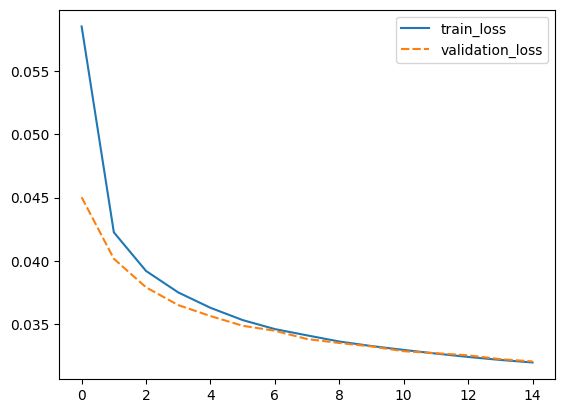

In [196]:
sns.lineplot(data=train_batch_df[["train_loss", "validation_loss"]])


In [162]:
# Save the trained model
torch.save(model.state_dict(), 'autoencoder_trained.pth')

In [197]:
# Inference using the trained model
## Extract some images
test_batch = iter(test_dataloader)
test_batch_image, test_batch_label = next(test_batch)

test_outputs=[]

model.eval()
with torch.no_grad():
  for idx, (img, label) in enumerate(test_dataloader):

    test_flattened_img=img.reshape(-1, 28*28)

    test_reconstruction_input=model.forward(test_flattened_img)
    test_mse_loss=loss(test_reconstruction_input, test_flattened_img)

    test_outputs.append({"batch_id": idx, "MSE": test_mse_loss.item()})

In [198]:
test_batch_df=pd.DataFrame(test_outputs)

test_batch_df.MSE.mean()

0.03218816074578068

# Compare original and reconstructed image

In [199]:
im=next(test_batch)[0][0]

In [202]:
# Reconstruct input image
model.eval()
with torch.no_grad():
  oos_reconstructed_input=model.forward(im.reshape(-1, 28*28))

oos_reconstructed_input_resized=oos_reconstructed_input.reshape(1, 28, 28)


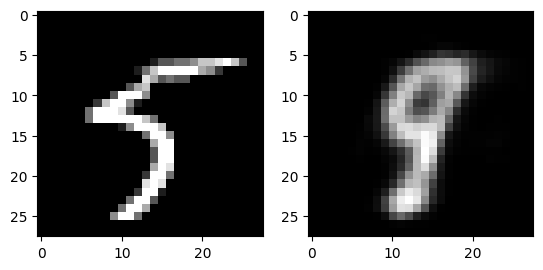

In [203]:
# Bring together original and reconstructed image
imgs=[im, oos_reconstructed_input_resized]

for idx, img in enumerate(imgs):
    plt.subplot(1,2, idx+1)
    plt.imshow(img[0, :, :], cmap='gray')
plt.show()